In [1]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h4 style="text-align: center;">{title}</h4>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [2]:
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from src.tde import time_delay_embedding
from src.model_selection import (MetaEstimator,
                                 search_space_with_feature_ext)

from config import CHAPTER_ASSETS, CHAPTER_OUTPUTS

CHAPTER = 'Chapter 3'
assets = CHAPTER_ASSETS[CHAPTER]
output_dir = CHAPTER_OUTPUTS[CHAPTER]

file = f'{assets}/IrishSmartBuoy.csv'

# reading the data set
# skipping the second with skiprows
# parsing time column to datetime
data = pd.read_csv(file, skiprows=[1], parse_dates=['time'], index_col='time')

# defining the series and converting cm to meters
series = data['SignificantWaveHeight'] / 100
# resampling to hourly and taking the mean
series = series.resample('H').mean()


In [6]:

# leaving last 20% of observations for testing
train, test = train_test_split(series, test_size=0.2, shuffle=False)

train.name = 'SWaveHeight'

# transforming time series into a tabular format for supervised learning
X_train, Y_train = time_delay_embedding(train, n_lags=24, horizon=24, return_Xy=True)
X_test, Y_test = time_delay_embedding(test, n_lags=24, horizon=24, return_Xy=True)


In [2]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from src.tde import time_delay_embedding
from src.model_selection import (MetaEstimator,
                                 search_space_with_feature_ext)


from config import ASSETS, OUTPUTS

CHAPTER = 'Part 1'
assets = ASSETS[CHAPTER]
output_dir = OUTPUTS[CHAPTER]

data = pd.read_csv(f'{assets}/wind_df.csv', parse_dates=['datetime'], index_col='datetime')
data.drop('rec_fcast', axis=1, inplace=True)
data = data.loc[[2013 < x < 2018 for x in data.index.year], :]
data.columns = ['Wind Power', 'Inst. Capacity']


data['Norm. Wind Power'] = data['Wind Power'] / data['Inst. Capacity']

series = data['Norm. Wind Power'].resample('H').mean()
series.iloc[np.where(series > 1)] = np.nan
series = series.ffill()

# modeling

# leaving last 20% of observations for testing
train, test = train_test_split(series, test_size=0.2, shuffle=False)

# transforming time series into a tabular format for supervised learning
X_train, Y_train = time_delay_embedding(train, n_lags=24, horizon=24, return_Xy=True)
X_test, Y_test = time_delay_embedding(test, n_lags=24, horizon=24, return_Xy=True)


In [5]:
display_side_by_side(X_train.round(3).iloc[:4,[0,-1]],Y_train.round(2).iloc[:4,[0,-1]], titles=['Explanatory variables','Target variables'])


,Norm. Wind Power(t-23),Norm. Wind Power(t)
datetime,,
2014-01-02 00:00:00,0.534,0.874
2014-01-02 01:00:00,0.517,0.902
2014-01-02 02:00:00,0.556,0.901
2014-01-02 03:00:00,0.546,0.904
,Norm. Wind Power(t+1),Norm. Wind Power(t+24)
datetime,,
2014-01-02 00:00:00,0.90,0.67
2014-01-02 01:00:00,0.90,0.36
2014-01-02 02:00:00,0.90,0.35


In [1]:
import re

import pandas as pd
from plotnine import *

from config import CHAPTER_ASSETS, CHAPTER_OUTPUTS
from src.log import LogTransformation

CHAPTER = 'Chapter 4'
assets = CHAPTER_ASSETS[CHAPTER]
output_dir = CHAPTER_OUTPUTS[CHAPTER]

DATE_TIME_COLS = ['month', 'day', 'calendar_year', 'hour']
STATION = 'smf1'

COLUMNS_PER_FILE = \
    {'incoming_solar_final.csv': DATE_TIME_COLS + [f'{STATION}_sin_w/m2'],
     'wind_dir_raw.csv': DATE_TIME_COLS + [f'{STATION}_wd_deg'],
     'snow_depth_final.csv': DATE_TIME_COLS + [f'{STATION}_sd_mm'],
     'wind_speed_final.csv': DATE_TIME_COLS + [f'{STATION}_ws_m/s'],
     'dewpoint_final.csv': DATE_TIME_COLS + [f'{STATION}_dpt_C'],
     'precipitation_final.csv': DATE_TIME_COLS + [f'{STATION}_ppt_mm'],
     'vapor_pressure.csv': DATE_TIME_COLS + [f'{STATION}_vp_Pa'],
     'relative_humidity_final.csv': DATE_TIME_COLS + [f'{STATION}_rh'],
     'air_temp_final.csv': DATE_TIME_COLS + [f'{STATION}_ta_C'],
     }

data_series = {}
for file in COLUMNS_PER_FILE:
    # file = 'incoming_solar_final.csv'

    file_data = pd.read_csv(f'{assets}/{file}')

    var_df = file_data[COLUMNS_PER_FILE[file]]

    var_df['datetime'] = \
        pd.to_datetime([f'{year}/{month}/{day} {hour}:00'
                        for year, month, day, hour in zip(var_df['calendar_year'],
                                                          var_df['month'],
                                                          var_df['day'],
                                                          var_df['hour'])])

    var_df = var_df.drop(DATE_TIME_COLS, axis=1)
    var_df = var_df.set_index('datetime')
    series = var_df.iloc[:, 0].sort_index()

    data_series[file] = series

mv_series = pd.concat(data_series, axis=1)
mv_series.columns = [re.sub('_final.csv|_raw.csv|.csv', '', x) for x in mv_series.columns]
mv_series.columns = [re.sub('_', ' ', x) for x in mv_series.columns]
mv_series.columns = [x.title() for x in mv_series.columns]
mv_series.columns = [re.sub('Incoming Solar', 'Solar Irradiance', x) for x in mv_series.columns]

mv_series = mv_series.astype(float)


/var/folders/4r/ptn78qsx2vgffms1_tb7v9xw0000gn/T/ipykernel_7895/2575391394.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4r/ptn78qsx2vgffms1_tb7v9xw0000gn/T/ipykernel_7895/2575391394.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4r/ptn78qsx2vgffms1_tb7v9xw0000gn/T/ipykernel_7895/2575391394.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [5]:
mv_series.iloc[10:15,:]

,Solar Irradiance,Wind Dir,Snow Depth,Wind Speed,Dewpoint,Precipitation,Vapor Pressure,Relative Humidity,Air Temp
datetime,,,,,,,,,
2007-10-01 10:00:00,63.8,331.0,0.0,0.5,1.8,0.7,696.0,0.97,2.2
2007-10-01 11:00:00,99.4,340.0,0.0,0.5,2.9,0.3,751.0,0.97,3.3
2007-10-01 12:00:00,174.5,335.0,0.0,0.7,3.5,0.2,787.0,0.96,4.2
2007-10-01 13:00:00,157.9,325.0,0.0,0.6,2.8,0.1,747.0,0.94,3.7
2007-10-01 14:00:00,345.8,327.0,0.0,0.8,2.8,0.4,749.0,0.91,4.1


In [ ]:
mv_series.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '80px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])]
)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sktime.transformations.series.date import DateTimeFeatures
from plotnine import *

from src.tde import time_delay_embedding
from src.fourier import FourierTerms
from config_hidden import ASSETS, OUTPUTS

CHAPTER = 'Part 4'
assets = ASSETS[CHAPTER]
output_dir = OUTPUTS[CHAPTER]

file = f'{assets}/pjm/EKPC_hourly.csv'

# Reading the data set
data = pd.read_csv(file, parse_dates=['Datetime'], index_col='Datetime')

series = data['EKPC_MW']
series.name = 'Demand'
series = series.resample('H').mean()

# Modeling

# Train / test split
train, test = train_test_split(series, test_size=0.2, shuffle=False)

# using past 12 observations as explanatory variables
N_LAGS = 12
# using the next 12 hours as the forecasting horizon
HORIZON = 12

# transforming time series into a tabular format for supervised learning
X_train, Y_train = time_delay_embedding(train, n_lags=N_LAGS, horizon=HORIZON, return_Xy=True)
X_test, Y_test = time_delay_embedding(test, n_lags=N_LAGS, horizon=HORIZON, return_Xy=True)

hourly_feats = DateTimeFeatures(ts_freq='H',
                                keep_original_columns=False,
                                feature_scope='efficient')

fourier_daily = FourierTerms(n_terms=1, period=24, prefix='D_')
fourier_monthly = FourierTerms(n_terms=1, period=24 * 30.5, prefix='M_')
fourier_yearly = FourierTerms(n_terms=1, period=24 * 365, prefix='Y_')

dtime_train = hourly_feats.fit_transform(X_train)
print(dtime_train.head())
dfourier_train = fourier_daily.transform(X_train.index)
mfourier_train = fourier_monthly.transform(X_train.index)
yfourier_train = fourier_yearly.transform(X_train.index)


                     year  quarter_of_year  month_of_year  week_of_year  \
Datetime                                                                  
2013-06-01 13:00:00  2013                2              6            22   
2013-06-01 14:00:00  2013                2              6            22   
2013-06-01 15:00:00  2013                2              6            22   
2013-06-01 16:00:00  2013                2              6            22   
2013-06-01 17:00:00  2013                2              6            22   

                     day_of_year  day_of_month  day_of_week  hour_of_day  
Datetime                                                                  
2013-06-01 13:00:00          152             1            5           13  
2013-06-01 14:00:00          152             1            5           14  
2013-06-01 15:00:00          152             1            5           15  
2013-06-01 16:00:00          152             1            5           16  
2013-06-01 17:00:00     

/Users/vcerq/miniconda/lib/python3.10/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
/Users/vcerq/miniconda/lib/python3.10/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.


<AxesSubplot: xlabel='Datetime'>

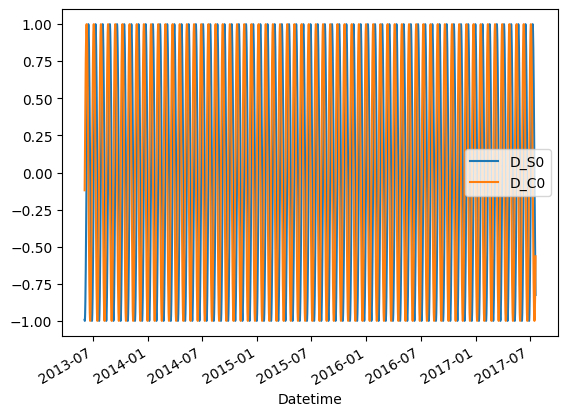

In [4]:
dfourier_train.plot()

In [3]:
import numpy as np
import pandas as pd
from plotnine import *

from config import ASSETS, OUTPUTS

PART = 'Part 7'
assets = ASSETS[PART]
output_dir = OUTPUTS[PART]

EXCLUDE_CATEGORIES = ['Alcohol', 'All Foods', 'Other']
TARGET_VAR = 'Dollars'

file = f'{assets}/NationalTotalAndSubcategory.csv'

# reading the data set
data = pd.read_csv(file)


pd.set_option('display.max_columns', None)

data = data.loc[data['variable'] == TARGET_VAR, :]
data = data.loc[~data['Category'].isin(EXCLUDE_CATEGORIES), :]
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data.set_index('Date', inplace=True)

data['ID'] = [f'{x}_{y}' for x, y in zip(data['Category'], data['Subcategory'])]

unique_prods = data.ID.unique().tolist()
prod_series = {}
for prod in unique_prods:
    prod_series[prod] = data.loc[data['ID'] == prod]['value'] / 1_000_000

prod_df = pd.DataFrame(prod_series)

prod_df = prod_df.sort_index()



In [15]:
prod_df.reset_index().round(1).iloc[:,[0,1,3,15,44,40]].head(8)

,Date,Beverages_Carbonated non-alcoholic,Beverages_Other,Dairy_Cheese,Vegetables_Orange fresh/frozen,Vegetables_Legumes canned
0,2019-10-06,734.2,227.1,422.3,55.1,40.5
1,2019-10-13,719.2,229.1,427.8,60.8,43.8
2,2019-10-20,693.7,225.5,418.2,66.8,42.1
3,2019-10-27,692.0,221.0,413.4,76.8,41.4
4,2019-11-03,690.8,231.8,419.7,59.5,43.8
5,2019-11-10,699.6,243.4,436.4,40.1,43.9
6,2019-11-17,685.7,241.8,435.4,41.9,42.9
7,2019-11-24,738.2,248.5,489.7,56.2,39.6


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from config import ASSETS, OUTPUTS

from src.spatial import SpatialGridDecomposition, ODFlowCounts

PART = 'Part 8'
assets = ASSETS[PART]
output_dir = OUTPUTS[PART]

TOP_K = 50

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


# reading the data set
df = pd.read_csv(f'{assets}/trips.csv', parse_dates=['time'])




In [2]:
df.set_index('time').drop('cab_trip_id', axis=1).head(5)

,latitude,longitude,occupancy,cab
time,,,,
2008-06-04 22:26:45+00:00,37.78401,-122.40783,1,enyenewl
2008-06-04 22:27:40+00:00,37.78490,-122.40734,1,enyenewl
2008-06-04 22:28:41+00:00,37.78500,-122.40661,1,enyenewl
2008-06-04 22:29:41+00:00,37.78540,-122.40648,1,enyenewl
2008-06-04 22:30:45+00:00,37.78562,-122.40562,1,enyenewl


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from config import ASSETS, OUTPUTS

from src.spatial import SpatialGridDecomposition, ODFlowCounts, prune_coordinates

PART = 'Part 8'
assets = ASSETS[PART]
output_dir = OUTPUTS[PART]

TOP_K = 50

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# reading the data set
trips_df = pd.read_csv(f'{assets}/trips.csv', parse_dates=['time'])
# df.set_index('time').drop('cab_trip_id', axis=1).head(5)

# removing outliers from coordinates
trips_df = prune_coordinates(trips_df=trips_df, lhs_thr=0.01, rhs_thr=0.99)

# grid decomposition with 10000 cells
grid = SpatialGridDecomposition(n_cells=15**2)
# setting bounding box
grid.set_bounding_box(lat=trips_df.latitude, lon=trips_df.longitude)
# grid decomposition
grid.grid_decomposition()


trips_df = trips_df.head(600000)

# getting origin and destination coordinates for each trip
df_group = trips_df.groupby(['cab', 'cab_trip_id'])
trip_points = df_group.apply(lambda x: ODFlowCounts.get_od_coordinates(x))
trip_points.reset_index(drop=True, inplace=True)

# getting the origin and destination cell centroid
od_pairs = trip_points.apply(lambda x: ODFlowCounts.get_od_centroids(x, grid.centroid_df), axis=1)

flow_count = od_pairs.value_counts().reset_index()
flow_count = flow_count.rename({0: 'count'}, axis=1)

top_od_pairs = flow_count.head(TOP_K)


trip_points = pd.concat([trip_points, od_pairs], axis=1)
trip_points = trip_points.sort_values('time_start')
trip_points.reset_index(drop=True, inplace=True)

trip_starts = []
for i, pair in top_od_pairs.iterrows():
    print(i)

    origin_match = trip_points['origin'] == pair['origin']
    dest_match = trip_points['destination'] == pair['destination']

    od_trip_df = trip_points.loc[origin_match & dest_match, :]
    od_trip_df.loc[:, 'pair'] = i

    trip_starts.append(od_trip_df[['time_start', 'time_end', 'pair']])

trip_starts_df = pd.concat(trip_starts, axis=0).reset_index(drop=True)
# trip_starts_df.set_index('time_start', inplace=True)

od_count_series = {}
for pair, data in trip_starts_df.groupby('pair'):
    print(data)

    new_index = pd.date_range(
        start=data.time_start.values[0],
        end=data.time_end.values[-1],
        freq='H',
        tz='UTC'
    )

    od_trip_counts = pd.Series(0, index=new_index)
    for _, r in data.iterrows():
        # r = data.iloc[50,:]
        dt = r['time_start'] - new_index
        dt_secs = dt.total_seconds()

        valid_idx = np.where(dt_secs >= 0)[0]
        idx = valid_idx[dt_secs[valid_idx].argmin()]

        od_trip_counts[new_index[idx]] += 1

    od_count_series[pair] = od_trip_counts.resample('H').mean()

od_df = pd.DataFrame(od_count_series)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
                    time_start                  time_end  pair
0    2008-05-17 10:16:32+00:00 2008-05-17 10:23:34+00:00     0
1    2008-05-17 14:27:49+00:00 2008-05-17 14:27:49+00:00     0
2    2008-05-17 15:21:23+00:00 2008-05-17 15:21:23+00:00     0
3    2008-05-17 16:40:44+00:00 2008-05-17 16:46:04+00:00     0
4    2008-05-17 17:21:35+00:00 2008-05-17 17:28:26+00:00     0
...                        ...                       ...   ...
1103 2008-06-09 16:03:10+00:00 2008-06-09 16:03:10+00:00     0
1104 2008-06-09 16:52:55+00:00 2008-06-09 16:55:51+00:00     0
1105 2008-06-09 17:46:10+00:00 2008-06-09 17:49:14+00:00     0
1106 2008-06-09 17:59:00+00:00 2008-06-09 17:59:58+00:00     0
1107 2008-06-09 18:00:00+00:00 2008-06-09 18:00:00+00:00     0

[1108 rows x 3 columns]


/var/folders/4r/ptn78qsx2vgffms1_tb7v9xw0000gn/T/ipykernel_6934/507911077.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_trip_df.loc[:, 'pair'] = i
/var/folders/4r/ptn78qsx2vgffms1_tb7v9xw0000gn/T/ipykernel_6934/507911077.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_trip_df.loc[:, 'pair'] = i
/var/folders/4r/ptn78qsx2vgffms1_tb7v9xw0000gn/T/ipykernel_6934/507911077.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

                    time_start                  time_end  pair
1108 2008-05-17 14:40:54+00:00 2008-05-17 14:43:40+00:00     1
1109 2008-05-17 14:52:45+00:00 2008-05-17 14:56:58+00:00     1
1110 2008-05-17 17:09:10+00:00 2008-05-17 17:18:06+00:00     1
1111 2008-05-17 17:16:38+00:00 2008-05-17 17:22:21+00:00     1
1112 2008-05-17 18:23:55+00:00 2008-05-17 18:30:26+00:00     1
...                        ...                       ...   ...
1878 2008-06-09 13:22:54+00:00 2008-06-09 13:32:21+00:00     1
1879 2008-06-09 16:47:25+00:00 2008-06-09 16:52:28+00:00     1
1880 2008-06-09 17:16:19+00:00 2008-06-09 17:22:22+00:00     1
1881 2008-06-09 17:48:09+00:00 2008-06-09 17:51:50+00:00     1
1882 2008-06-09 17:51:44+00:00 2008-06-09 17:55:42+00:00     1

[775 rows x 3 columns]
                    time_start                  time_end  pair
1883 2008-05-17 14:16:09+00:00 2008-05-17 14:23:13+00:00     2
1884 2008-05-17 14:38:18+00:00 2008-05-17 14:42:45+00:00     2
1885 2008-05-17 14:48:16+00:00 

                    time_start                  time_end  pair
7002 2008-05-17 17:13:34+00:00 2008-05-17 17:18:23+00:00    13
7003 2008-05-17 18:32:53+00:00 2008-05-17 18:45:12+00:00    13
7004 2008-05-17 21:04:17+00:00 2008-05-17 21:19:19+00:00    13
7005 2008-05-17 21:59:59+00:00 2008-05-17 22:15:00+00:00    13
7006 2008-05-17 22:04:39+00:00 2008-05-17 22:13:19+00:00    13
...                        ...                       ...   ...
7354 2008-06-09 02:47:38+00:00 2008-06-09 02:53:02+00:00    13
7355 2008-06-09 03:10:03+00:00 2008-06-09 03:21:00+00:00    13
7356 2008-06-09 04:08:55+00:00 2008-06-09 04:17:46+00:00    13
7357 2008-06-09 08:56:08+00:00 2008-06-09 09:01:35+00:00    13
7358 2008-06-09 09:57:27+00:00 2008-06-09 10:01:21+00:00    13

[357 rows x 3 columns]
                    time_start                  time_end  pair
7359 2008-05-17 18:46:27+00:00 2008-05-17 18:57:16+00:00    14
7360 2008-05-17 19:56:48+00:00 2008-05-17 20:06:23+00:00    14
7361 2008-05-17 20:05:33+00:00 

<AxesSubplot: >

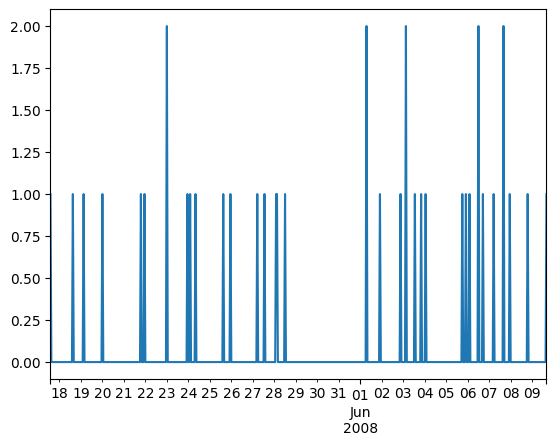

In [18]:
od_df[19].dropna().plot()

In [17]:
od_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
2008-05-17 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05-17 15:00:00+00:00,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2008-05-17 16:00:00+00:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
2008-05-17 17:00:00+00:00,1.0,NaN,1.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2008-05-17 18:00:00+00:00,0.0,NaN,1.0,NaN,0.0,1.0,1.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-09 13:00:00+00:00,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN
2008-06-09 14:00:00+00:00,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-06-09 15:00:00+00:00,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2008-06-09 16:00:00+00:00,NaN,NaN,1.0,1.0,1.0,NaN,NaN,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
flow_count

,origin,destination,count
0,110,110,68
1,110,81,58
2,776,110,52
3,83,110,51
4,107,110,50
...,...,...,...
11908,128,194,1
11909,128,167,1
11910,128,145,1
11911,128,142,1
